<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session4/EVA4_Session_4_Attempt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

# torch is the main module that holds all the things you need for Tensor computation
import torch

# nn module provides many classes and functions to build neural networks.
# models, all kinds of layers, activation functions, parameter classes, etc
import torch.nn as nn   

# functional api such as relu
import torch.nn.functional as F

# it offers all the optimizers like SGD, ADAM
import torch.optim as optim

#Torchvision is a package in the PyTorch library containing computer-vision models, datasets, and image transformations
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Build the neural network, expand on top of nn.Module
# All network classes in PyTorch expand on the base class: nn.Module. 
# It packs all the basics: weights, biases, forward method and also some utility attributes and methods like .parameters() and zero_grad()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.dropout_val = 0.05

        self.conv_blk1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, bias=False),   #Output: 8X26X26,  GRF: 3X3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, bias=False),  #Output: 16X24X24, GRF: 5X5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, bias=False), #Output: 16X22X22, GRF: 7X7
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        self.conv_blk1_transition = nn.Sequential(
            nn.Conv2d(16, 8, 1, bias=False),  #Output: 8X22X22 (combining channels)
            nn.MaxPool2d(2, 2),               #Output: 8X11X11, GRF: 8X8
            nn.Dropout(self.dropout_val)
        )

        self.conv_blk2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, bias=False),  #Output: 16X9X9, GRF: 12X12
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, bias=False), #Output: 16X7X7, GRF: 16X16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, bias=False), #Output: 16X5X5, GRF: 20X20
            # nn.ReLU()
            # no ReLU for last covv layer
            # no batch norm and dropout as this conv layer is close to output layer
        )

        self.avgpool = nn.AvgPool2d(kernel_size=5) #Output: 16X1X1 (GAP layer)
        self.conv_class10 = nn.Conv2d(16, 10, 1, bias=False)  #Output: 10X1X1, combining to 10 channels as we need 10 classes for predictions

    def forward(self, x):

        x = self.conv_blk1(x)               # convolution block-1
        x = self.conv_blk1_transition(x)    # combining channels followed by maxpool

        x = self.conv_blk2(x)               # convolution block-2

        x = self.avgpool(x)                 # GAP layer
        x = self.conv_class10(x)

        # flatten the tensor so it can be passed to the dense layer afterward
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary

# checking if GPU is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 16, 22, 22]           2,304
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
           Conv2d-10            [-1, 8, 22, 22]             128
        MaxPool2d-11            [-1, 8, 11, 11]               0
          Dropout-12            [-1, 8, 11, 11]               0
           Conv2d-13             [-1, 16, 9, 9]           1,152
             ReLU-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1) # seeding is added so that everytime we run this notebook we get the same result
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Description for datasets.MNIST
# followed link: https://www.aiworkbox.com/lessons/load-mnist-dataset-from-pytorch-torchvision
# root: root parameter is to define where to save the data. here: '../data'
# The train parameter is set to true because we are initializing the MNIST training dataset.
# The download parameter is set to true because we want to download it if it’s not already present in our data folder.
# The transform parameter is used for image manipulation transforms. here we are normalizing the training dataset
# transforms.ToTensor to turn images into Tensor so we can directly use it with our network

# DataLoader: it can load multiple samples parallelly using torch.multiprocessing workers
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# The train parameter is set to false because we want test set, not the train set.
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


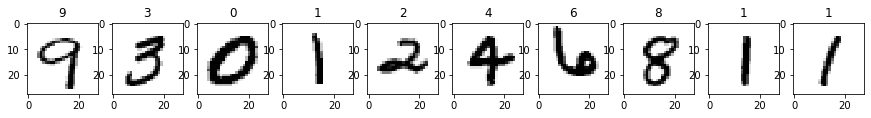

In [0]:
# Viewing data examples used for training
fig, axis = plt.subplots(1, 10, figsize=(15, 10))
images, labels = next(iter(train_loader))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]

        ax.imshow(image.view(28, 28), cmap='binary') # add image
        ax.set(title = f"{label}") # add label

In [0]:
from tqdm import tqdm

# referred: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    n_correct = 0
    n_total = 0
    train_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device) # converting the data into GPU format
        optimizer.zero_grad() # clearing the Gradients of the model parameters
        output = model(data) # prediction for training and validation set
        loss = F.nll_loss(output, target) # computing the training loss
        loss.backward() # computing the updated weights of all the model parameters
        optimizer.step()
        
        # computing training accuracy
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        n_correct += pred.eq(target.view_as(pred)).sum().item()
        n_total += data.shape[0]
        t_acc = 100. * n_correct/n_total

        progress_desc = 'Epoch: {} (batch_id={}) ==> loss={:.6f} acc={:.2f}'.format(epoch, batch_idx+1, loss.item(), t_acc,)
        #pbar.set_description(desc= f'Epoch: {epoch} ==> loss={loss.item()} acc={train_acc} batch_id={batch_idx}') 
        pbar.set_description(desc=progress_desc)     
    
    train_acc = 100. * n_correct/len(train_loader.dataset)
    return train_acc 


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) # converting the data into GPU format
            output = model(data) # prediction for validation set
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_acc

In [0]:
model = Net().to(device)
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) 

# Learning rate scheduler to changing LR every epoch
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=16, gamma=0.1, last_epoch=-1)

epochs = 20
train_acc_hist, test_acc_hist = [], []

for epoch in range(1, epochs+1): # run for 20 epochs
    train_acc = train(model, device, train_loader, optimizer, epoch)
    train_acc_hist.append(train_acc) # storing training accuracy history for each epoch

    lr_scheduler.step() # update the learning rate for start_epoch times

    test_acc = test(model, device, test_loader) # prediction on test data
    test_acc_hist.append(test_acc)  # storing test accuracy history for each epoch

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Epoch: 1 (batch_id=469) ==> loss=0.089710 acc=88.91: 100%|██████████| 469/469 [00:12<00:00, 37.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0757, Accuracy: 9768/10000 (97.68%)



Epoch: 2 (batch_id=469) ==> loss=0.058968 acc=98.03: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9862/10000 (98.62%)



Epoch: 3 (batch_id=469) ==> loss=0.040869 acc=98.49: 100%|██████████| 469/469 [00:12<00:00, 39.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9854/10000 (98.54%)



Epoch: 4 (batch_id=469) ==> loss=0.100702 acc=98.73: 100%|██████████| 469/469 [00:11<00:00, 39.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9883/10000 (98.83%)



Epoch: 5 (batch_id=469) ==> loss=0.038326 acc=98.90: 100%|██████████| 469/469 [00:11<00:00, 39.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9907/10000 (99.07%)



Epoch: 6 (batch_id=469) ==> loss=0.042999 acc=99.01: 100%|██████████| 469/469 [00:11<00:00, 39.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9901/10000 (99.01%)



Epoch: 7 (batch_id=469) ==> loss=0.006966 acc=99.15: 100%|██████████| 469/469 [00:12<00:00, 37.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9911/10000 (99.11%)



Epoch: 8 (batch_id=469) ==> loss=0.082804 acc=99.19: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.17%)



Epoch: 9 (batch_id=469) ==> loss=0.006199 acc=99.22: 100%|██████████| 469/469 [00:11<00:00, 41.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)



Epoch: 10 (batch_id=469) ==> loss=0.008844 acc=99.30: 100%|██████████| 469/469 [00:12<00:00, 38.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9919/10000 (99.19%)



Epoch: 11 (batch_id=469) ==> loss=0.004852 acc=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9898/10000 (98.98%)



Epoch: 12 (batch_id=469) ==> loss=0.026372 acc=99.34: 100%|██████████| 469/469 [00:11<00:00, 39.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)



Epoch: 13 (batch_id=469) ==> loss=0.001988 acc=99.39: 100%|██████████| 469/469 [00:11<00:00, 39.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99.19%)



Epoch: 14 (batch_id=469) ==> loss=0.075878 acc=99.48: 100%|██████████| 469/469 [00:11<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9908/10000 (99.08%)



Epoch: 15 (batch_id=469) ==> loss=0.019275 acc=99.44: 100%|██████████| 469/469 [00:11<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)



Epoch: 16 (batch_id=469) ==> loss=0.013493 acc=99.50: 100%|██████████| 469/469 [00:12<00:00, 38.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)



Epoch: 17 (batch_id=469) ==> loss=0.004303 acc=99.66: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9946/10000 (99.46%)



Epoch: 18 (batch_id=469) ==> loss=0.025840 acc=99.73: 100%|██████████| 469/469 [00:11<00:00, 40.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9945/10000 (99.45%)



Epoch: 19 (batch_id=469) ==> loss=0.001330 acc=99.73: 100%|██████████| 469/469 [00:12<00:00, 38.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9944/10000 (99.44%)



Epoch: 20 (batch_id=469) ==> loss=0.003399 acc=99.74: 100%|██████████| 469/469 [00:11<00:00, 42.23it/s]



Test set: Average loss: 0.0214, Accuracy: 9945/10000 (99.45%)



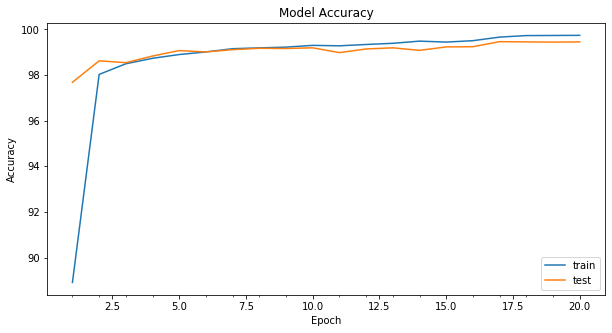

In [0]:
# utility fxn to plot accuracy history for the model. This is to visualize how model is converging.
def plot_model_history(train_accu, test_accu):
    
    fig = plt.figure(figsize=(10,5))
    axs = plt.axes()
    # summarize history for accuracy

    axs.plot(range(1,len(train_accu)+1), train_accu)
    axs.plot(range(1,len(test_accu)+1),test_accu)

    axs.set_title('Model Accuracy')
    axs.set_ylabel('Accuracy')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(train_accu)+1),len(train_accu)/10)
    axs.legend(["train", "test"], loc='best')


plot_model_history(train_acc_hist, test_acc_hist)